In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt
import re
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

# 1. ЗАГРУЗКА ДАННЫХ
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train['product_id'].nunique()

485

In [6]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Создаем временные ряды (товары в строках, даты в колонках)
# Используем p05 (нижнюю границу) как основной индикатор поведения цены
tickers_df = train.pivot(index='product_id', columns='dt', values='price_p05')

# 2. Масштабируем данные (MeanVariance делает среднее=0, дисперсию=1)
# Это важно, чтобы DTW смотрел на форму графика, а не на то, что один товар стоит 100р, а другой 1000р
scaler = TimeSeriesScalerMeanVariance()
tickers_scaled = scaler.fit_transform(tickers_df.values)

In [7]:
tickers_df

dt,2024-03-28,2024-03-29,2024-03-30,2024-03-31,2024-04-01,2024-04-02,2024-04-03,2024-04-04,2024-04-05,2024-04-06,...,2024-05-17,2024-05-18,2024-05-19,2024-05-20,2024-05-21,2024-05-22,2024-05-23,2024-05-24,2024-05-25,2024-05-26
product_id,,,,,,,,,,,,,,,,,,,,,
0,1.136102,1.133129,1.134522,1.152592,1.166641,1.102758,1.116244,1.171616,1.043815,1.106378,...,0.899839,0.983198,0.968045,0.983709,2.364929,2.303391,0.989400,0.965440,0.983856,0.949948
4,1.181238,1.154368,1.147127,1.147305,1.124731,1.177808,1.159825,1.198479,1.172120,1.078727,...,0.991772,1.008050,1.015163,1.000861,1.009134,1.017228,0.989574,0.958046,1.014202,0.996904
6,1.086622,1.177930,1.162226,1.158573,1.155649,1.155961,1.140810,1.169654,1.240015,1.169073,...,1.089626,1.166182,1.166599,1.192850,1.211353,1.133544,1.131502,1.179956,1.198228,1.095942
7,1.143681,1.163522,1.152524,2.067129,1.999332,1.108316,1.012180,1.105675,1.097680,1.129968,...,1.132574,1.084680,1.145603,1.131086,1.189587,1.165239,1.131384,1.131160,1.178358,1.140987
8,0.523833,0.500485,1.010895,0.973546,1.193071,1.178513,1.117553,1.090892,1.087873,1.094084,...,1.015126,1.041352,1.043489,1.064095,1.166801,1.180247,1.082081,1.029957,0.986370,1.045841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,1.206618,1.110065,1.166930,1.193373,1.246105,1.151120,1.212212,1.197043,1.197296,1.223662,...,1.209992,1.191105,1.107493,1.229377,1.154236,1.132495,1.189004,0.897165,0.959575,0.859616
628,1.030049,1.059234,1.044939,0.980068,1.060335,0.800658,0.816771,0.769351,0.697500,0.700368,...,1.242017,1.172729,1.138500,1.180883,1.115911,1.159213,1.247764,1.134205,1.174879,1.109748
630,1.213775,1.171525,1.142124,1.097556,1.149807,1.188082,1.065140,1.192113,1.190364,1.155090,...,1.149950,1.120609,1.054478,1.083749,1.123819,1.012110,1.083311,1.069190,0.939361,0.949566


100%|██████████| 9/9 [05:58<00:00, 39.87s/it]


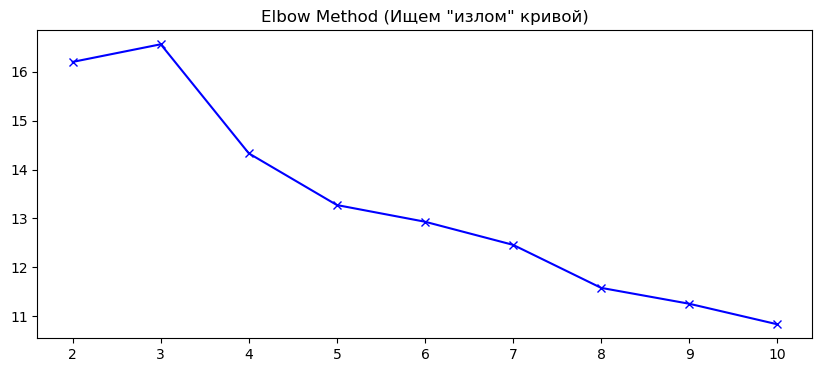

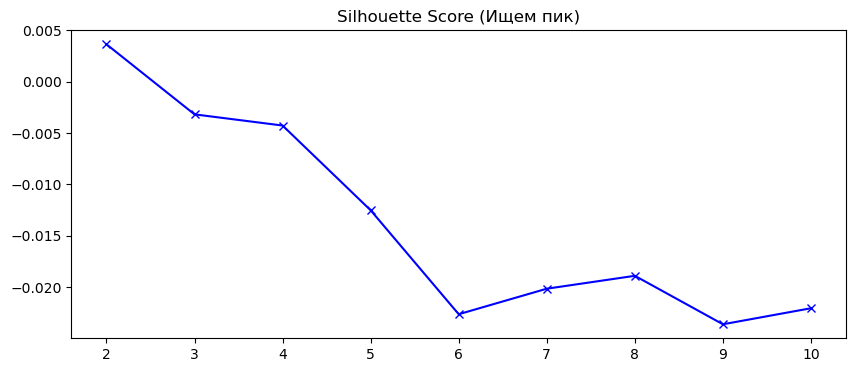

In [8]:
distortions = []
silhouette = []
K = range(2, 11) # Начинаем с 2, так как силуэт не считается для 1 кластера

for k in tqdm(K):
    # n_jobs=-1 задействует все ядра процессора
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=-1, max_iter=5, random_state=42)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled.reshape(len(tickers_df), -1), kmeanModel.labels_))

# График локтя
plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.title('Elbow Method (Ищем "излом" кривой)')
plt.show()

# График силуэта
plt.figure(figsize=(10,4))
plt.plot(K, silhouette, 'bx-')
plt.title('Silhouette Score (Ищем пик)')
plt.show()

In [ ]:
n_clusters = 4 # Выбери число на основе графиков выше
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=-1, max_iter=10, random_state=42)
cluster_labels = ts_kmeans_dtw.fit_predict(tickers_scaled)

# Визуализация центроидов (средних графиков цен для каждого кластера)
plt.figure(figsize=(12,6))
for i in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[i, :, 0].T, label=f"Cluster {i}")
plt.title("Типичные траектории цен по кластерам")
plt.legend()
plt.show()

# Создаем маппинг Product_ID -> Cluster
cluster_mapping = pd.Series(cluster_labels, index=tickers_df.index).to_dict()

# Добавляем в основной датасет
train['dtw_cluster'] = train['product_id'].map(cluster_mapping)
test['dtw_cluster'] = test['product_id'].map(cluster_mapping)

In [ ]:
# ОБЯЗАТЕЛЬНО добавь новый признак в список для CatBoost
if 'dtw_cluster' not in cat_features:
    cat_features.append('dtw_cluster')
    features.append('dtw_cluster')

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tqdm import tqdm

# 1. ЗАГРУЗКА ДАННЫХ
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train[train['price_p05'] > 0]
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# === БЛОК DTW КЛАСТЕРИЗАЦИИ ===
print("Запуск DTW кластеризации...")
# Готовим данные: товары в строках, даты в колонках
tickers_df = train.pivot(index='product_id', columns='dt', values='price_p05')
tickers_df = tickers_df.ffill(axis=1).bfill(axis=1).fillna(0)

# Масштабируем
scaler = TimeSeriesScalerMeanVariance()
tickers_scaled = scaler.fit_transform(tickers_df.values)

# Обучаем модель на 4 кластера (как решили по графикам)
n_clusters = 4 
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=-1, max_iter=10, random_state=42)
cluster_labels = ts_kmeans_dtw.fit_predict(tickers_scaled)

# Мапим кластеры на product_id
cluster_mapping = pd.Series(cluster_labels, index=tickers_df.index).to_dict()

# Добавляем новую фичу в train и test
train['dtw_cluster'] = train['product_id'].map(cluster_mapping).fillna(-1).astype(int)
test['dtw_cluster'] = test['product_id'].map(cluster_mapping).fillna(-1).astype(int)
# ==============================

# 2. ДОБАВЛЕНИЕ ЦИКЛИЧЕСКИХ ПРИЗНАКОВ
def add_cyclical_features(df):
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 3. ОПРЕДЕЛЕНИЕ ПРИЗНАКОВ
cat_features = [
    'management_group_id', 'first_category_id', 'second_category_id', 
    'third_category_id', 'product_id', 'activity_flag', 
    'dtw_cluster'  # <-- Наша новая фича здесь
]

features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year',
    'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos'
] + cat_features

# 4. ВАЛИДАЦИЯ (80/20 внутри каждого дня)
train_parts, val_parts = [], []
for date, group in train.groupby('dt'):
    group = group.sample(frac=1, random_state=42).reset_index(drop=True)
    split_idx = int(len(group) * 0.8)
    train_parts.append(group.iloc[:split_idx])
    val_parts.append(group.iloc[split_idx:])

train_part = pd.concat(train_parts).reset_index(drop=True)
val_part = pd.concat(val_parts).reset_index(drop=True)

# 5. ОБУЧЕНИЕ (с использованием cat_features)
cb_params = {
    'iterations': 2000,
    'learning_rate': 0.03,
    'depth': 8,
    'loss_function': 'MAE',
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds': 500,
    'thread_count': -1
}

model_low = CatBoostRegressor(**cb_params)
model_low.fit(train_part[features], train_part['price_p05'], 
              eval_set=(val_part[features], val_part['price_p05']), 
              cat_features=cat_features, use_best_model=True)

model_high = CatBoostRegressor(**cb_params)
model_high.fit(train_part[features], train_part['price_p95'], 
               eval_set=(val_part[features], val_part['price_p95']), 
               cat_features=cat_features, use_best_model=True)

In [3]:
def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

In [4]:
# Теперь смотрим сколько итераций реально понадобилось (ИСПРАВЛЕНО: убрали _val)
print(f"Лучшая итерация low: {model_low.get_best_iteration()}")
print(f"Лучшая итерация high: {model_high.get_best_iteration()}")

p_low_val = model_low.predict(val_part[features])
p_high_val = model_high.predict(val_part[features])
val_score = calculate_iou(val_part['price_p05'], val_part['price_p95'], p_low_val, p_high_val)
print(f"Валидационный IoU (CatBoost): {val_score:.4f}")

# ФИНАЛЬНОЕ ОБУЧЕНИЕ на полном датасете
print("Обучение финальной модели на полном датасете...")

# Создаем копии параметров, фиксируем итерации (ИСПРАВЛЕНО: убрали _val)
params_low_final = cb_params.copy()
params_low_final['iterations'] = model_low.get_best_iteration() + 1
params_low_final.pop('early_stopping_rounds', None) 

params_high_final = cb_params.copy()
params_high_final['iterations'] = model_high.get_best_iteration() + 1
params_high_final.pop('early_stopping_rounds', None)

final_model_low = CatBoostRegressor(**params_low_final)
final_model_high = CatBoostRegressor(**params_high_final)

# ВАЖНО: при финальном обучении тоже нужно указывать cat_features
final_model_low.fit(train[features], train['price_p05'], cat_features=cat_features, verbose=100)
final_model_high.fit(train[features], train['price_p95'], cat_features=cat_features, verbose=100)

# 6. ПРЕДСКАЗАНИЕ ДЛЯ TEST.CSV
print("Создание предсказаний...")
test['price_p05'] = final_model_low.predict(test[features])
test['price_p95'] = final_model_high.predict(test[features])
# Гарантируем, что верхняя граница выше нижней
test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

# 7. СОХРАНЕНИЕ SUBMISSION
submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv успешно сохранен!")

Лучшая итерация low: 86
Лучшая итерация high: 148
Валидационный IoU (CatBoost): 0.1898
Обучение финальной модели на полном датасете...
0:	learn: 0.1469761	total: 25.8ms	remaining: 2.22s
86:	learn: 0.0995290	total: 2.28s	remaining: 0us
0:	learn: 0.0982258	total: 26.1ms	remaining: 3.87s
100:	learn: 0.0832438	total: 2.61s	remaining: 1.24s
148:	learn: 0.0820897	total: 4.07s	remaining: 0us
Создание предсказаний...
Файл submission.csv успешно сохранен!


In [5]:
from dtaidistance import dtw
from sklearn.manifold import MDS

# 1. Считаем матрицу расстояний (без использования C-ядра)
print("Расчет матрицы расстояний...")
# Это займет время, так как идет сравнение 485x485
dist_matrix = dtw.distance_matrix(tickers_scaled.reshape(len(tickers_df), -1), use_c=False)

# 2. Превращаем матрицу в 2 координаты
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
dtw_coordinates = mds.fit_transform(dist_matrix)

# 3. Добавляем как новые фичи
dtw_coords_df = pd.DataFrame(
    dtw_coordinates, 
    columns=['dtw_x', 'dtw_y'], 
    index=tickers_df.index
).reset_index()

train = train.merge(dtw_coords_df, on='product_id', how='left')
test = test.merge(dtw_coords_df, on='product_id', how='left')

# Добавляем в список признаков (это числовые фичи, не категориальные)
features += ['dtw_x', 'dtw_y']

Расчет матрицы расстояний...


In [8]:
train = train[train['price_p05'] > 0]
train.shape

train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# 2. ДОБАВЛЕНИЕ ЦИКЛИЧЕСКИХ ПРИЗНАКОВ
def add_cyclical_features(df):
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 3. ОПРЕДЕЛЕНИЕ ПРИЗНАКОВ И КАТЕГОРИЙ
# Важно: CatBoost любит, когда категории передаются как int или string

features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year',
    'dow_sin', 'dow_cos', 
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    
    'management_group_id', 'first_category_id', 'second_category_id', 
    'third_category_id', 'product_id', 
    'activity_flag',

    'dtw_x', 'dtw_y'
]

# 4. ВАЛИДАЦИЯ (Разбиение 80/20 внутри каждого дня)
train_parts = []
val_parts = []

# Группируем по дате и делим каждую группу
for date, group in train.groupby('dt'):
    # Перемешиваем данные внутри дня (опционально, но желательно)
    group = group.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Вычисляем индекс разделения
    split_idx = int(len(group) * 0.8)
    
    train_parts.append(group.iloc[:split_idx])
    val_parts.append(group.iloc[split_idx:])

# Собираем все обратно в DataFrame
train_part = pd.concat(train_parts).reset_index(drop=True)
val_part = pd.concat(val_parts).reset_index(drop=True)

print(f"Размер обучающей выборки: {train_part.shape}")
print(f"Размер валидационной выборки: {val_part.shape}")

# Далее идет расчет IoU и обучение моделей (как в твоем коде)

def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

# Изменяем параметры CatBoost
cb_params = {
    'iterations': 2000,          # Увеличим число итераций, т.к. early stopping сам остановит обучение
    'learning_rate': 0.03,
    'depth': 8,
    'loss_function': 'MAE',      # Или 'Quantile:alpha=0.05' / 'Quantile:alpha=0.95'
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds': 500, # Остановиться, если метрика не улучшается 100 итераций
    'thread_count': -1
}

print("Обучение моделей с использованием валидации и Early Stopping...")

# Обучаем модель для нижней границы
model_low_val = CatBoostRegressor(**cb_params)
model_low_val.fit(
    train_part[features], train_part['price_p05'],
    eval_set=(val_part[features], val_part['price_p05']), # Добавляем валидационный сет
    use_best_model=True # Использовать веса лучшей итерации
)

# Обучаем модель для верхней границы
model_high_val = CatBoostRegressor(**cb_params)
model_high_val.fit(
    train_part[features], train_part['price_p95'],
    eval_set=(val_part[features], val_part['price_p95']), # Добавляем валидационный сет
    use_best_model=True
)

# Теперь смотрим сколько итераций реально понадобилось
print(f"Лучшая итерация low: {model_low_val.get_best_iteration()}")
print(f"Лучшая итерация high: {model_high_val.get_best_iteration()}")

p_low_val = model_low_val.predict(val_part[features])
p_high_val = model_high_val.predict(val_part[features])
val_score = calculate_iou(val_part['price_p05'], val_part['price_p95'], p_low_val, p_high_val)
print(f"Валидационный IoU (CatBoost): {val_score:.4f}")

# ФИНАЛЬНОЕ ОБУЧЕНИЕ на полном датасете
print("Обучение финальной модели на полном датасете...")

# Создаем копии параметров, но фиксируем количество итераций из валидации
params_low_final = cb_params.copy()
params_low_final['iterations'] = model_low_val.get_best_iteration() + 1
params_low_final.pop('early_stopping_rounds', None) # Удаляем за ненадобностью

params_high_final = cb_params.copy()
params_high_final['iterations'] = model_high_val.get_best_iteration() + 1
params_high_final.pop('early_stopping_rounds', None)

final_model_low = CatBoostRegressor(**params_low_final)
final_model_high = CatBoostRegressor(**params_high_final)

final_model_low.fit(train[features], train['price_p05'])
final_model_high.fit(train[features], train['price_p95'])

# 6. ПРЕДСКАЗАНИЕ ДЛЯ TEST.CSV
print("Создание предсказаний...")
test['price_p05'] = final_model_low.predict(test[features])
test['price_p95'] = final_model_high.predict(test[features])
test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

# 7. СОХРАНЕНИЕ SUBMISSION
submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv успешно сохранен!")

Размер обучающей выборки: (23176, 28)
Размер валидационной выборки: (5820, 28)
Обучение моделей с использованием валидации и Early Stopping...
0:	learn: 0.1471954	test: 0.1467316	best: 0.1467316 (0)	total: 6.16ms	remaining: 12.3s
100:	learn: 0.1028818	test: 0.1160931	best: 0.1160931 (100)	total: 513ms	remaining: 9.65s
200:	learn: 0.0953953	test: 0.1160260	best: 0.1157271 (144)	total: 1.02s	remaining: 9.16s
300:	learn: 0.0905460	test: 0.1164453	best: 0.1157271 (144)	total: 1.53s	remaining: 8.64s
400:	learn: 0.0870933	test: 0.1164869	best: 0.1157271 (144)	total: 2.08s	remaining: 8.3s
500:	learn: 0.0843553	test: 0.1167848	best: 0.1157271 (144)	total: 2.59s	remaining: 7.75s
600:	learn: 0.0820579	test: 0.1170889	best: 0.1157271 (144)	total: 3.11s	remaining: 7.24s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.1157270965
bestIteration = 144

Shrink model to first 145 iterations.
0:	learn: 0.0986513	test: 0.0984510	best: 0.0984510 (0)	total: 6.19ms	remaining: 12.4s
100:	